In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt

# Dataset Normalization

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Cifar-10 Dataset AutoLoad

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes=('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Check dataset

In [5]:
for i,j in testset:
    print(i.shape,j)
    break

torch.Size([3, 32, 32]) 3


Image size => 32, 32  
channel 3 => r, g, b  
label => 3(cat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [ 2732 21243 30403 32103 20757 14935 15430 39512]
torch.Size([3, 67, 133])


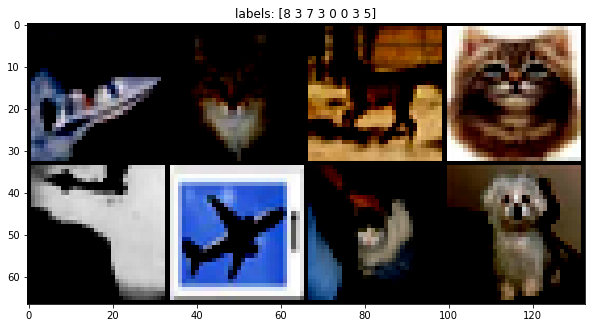

In [6]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(0)

# define helper function
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))

    plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(np.array(y)))

# pick random samples
grid_size = 8
rnd_inds = np.random.randint(0, len(trainset), grid_size)
print('image indices:', rnd_inds)

# create a grid from the sample images
x_grid = [trainset[i][0] for i in rnd_inds]
y_grid = [trainset[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=1)
print(x_grid.shape)

plt.figure(figsize=(10.0, 10.0))
show(x_grid, y_grid)

## Count Label Code

In [7]:
y_train = [y for _, y in trainset]
y_val = [y for _, y in valset]
y_test=[y for _,y in testset]

In [8]:
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [9]:
import collections

In [10]:
counter_train = collections.Counter(y_train)
counter_val = collections.Counter(y_val)
counter_test = collections.Counter(y_test)
print(counter_train)
print(counter_val)
print(counter_test)

Counter({2: 4032, 1: 4023, 5: 4016, 0: 4006, 8: 4001, 3: 4000, 7: 3992, 9: 3985, 6: 3974, 4: 3971})
Counter({4: 1029, 6: 1026, 9: 1015, 7: 1008, 3: 1000, 8: 999, 0: 994, 5: 984, 1: 977, 2: 968})
Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


Why Check the num of label?

Calculation Channel  
(N - F) / Stride + 1

In [11]:
class B_CNN(nn.Module):
    def __init__(self):
        super(B_CNN, self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,
                             out_channels=32,
                             kernel_size=6,
                             stride=2,
                             padding=2) # 32 16 16
                            #(36 - 6) / 2 + 1 => 16
        self.conv2=nn.Conv2d(in_channels=32,
                            out_channels=64,
                            kernel_size=5,
                            stride=2,
                            padding=2) # 64 8 8
                            #((20 - 5) / 2)=> 7로 파단 즉 사이드 하지않음 + 1 => 8
        self.conv3=nn.Conv2d(in_channels=64,
                            out_channels=128,
                            kernel_size=3,
                            stride=1,
                            padding=1) # 128 8 8
                            # kernel 3 에 stride 1 padding 1은 무조건 아웃풋 사이즈 동일
        self.maxpool1=nn.MaxPool2d(kernel_size=2,
                                  stride=2)
        self.act=nn.ReLU()
        self.fc = nn.Linear(2048,10)
    def forward(self,x):
        x=self.conv1(x)
        x=self.act(x)
        x=self.conv2(x)
        x=self.act(x)
        x=self.conv3(x)
        x=self.act(x)
        x=self.maxpool1(x) # 128 4 4
        x=x.view(x.size(0),-1) # 1 dim으로 변경시켜주는 함수 2048
        x=self.fc(x)
        return x

In [12]:
def dimension_check():
    net=B_CNN()
    x=torch.randn(1,3,32,32)
    y=net(x)
    print(y.size())

In [13]:
dimension_check()

torch.Size([1, 10])


In [14]:
def train(net,partition,optimizer,criterion):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                             batch_size=128,
                                             shuffle=True)
    net.train()
    correct = 0
    total =0
    train_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 0)):
        time.sleep(0.0000001)
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        #break
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #if i % 200 == 0:
        #    print(correct,train_loss)
    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [15]:
def test(net, partition):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=128, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [16]:
def validate(net, partition, criterion):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=128, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in tqdm(valloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [17]:
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
import time

In [18]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
net=B_CNN()
net.cuda()
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0015, weight_decay=0.00001)
train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]
for epoch in range(5):
    ts=time.time()
    net, train_loss,train_acc=train(net, partition, optimizer, criterion)
    val_loss, val_acc = validate(net, partition, criterion)
    te=time.time()
    print('time : {:2.2f}, train_loss : {:2.2f}, train_acc : {:2.2f},val_acc : {:2.2f},val_loss : {:2.2f}'.format(te-ts,train_loss,train_acc,val_acc,val_loss))
    train_loss=round(train_loss,2)
    val_loss=round(val_loss,2)
    train_acc=round(train_acc,2)
    val_acc=round(val_acc,2)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
test_acc = test(net,partition)
test_acc=round(test_acc,2)

  2%|▏         | 5/313 [00:00<00:06, 44.10it/s]

time : 6.64, train_loss : 1.52, train_acc : 44.95,val_acc : 54.82,val_loss : 1.27


  2%|▏         | 5/313 [00:00<00:06, 47.23it/s]

time : 6.50, train_loss : 1.13, train_acc : 60.12,val_acc : 62.41,val_loss : 1.07


  2%|▏         | 6/313 [00:00<00:05, 52.06it/s]

time : 6.48, train_loss : 0.96, train_acc : 66.41,val_acc : 65.65,val_loss : 0.99


  2%|▏         | 5/313 [00:00<00:06, 47.34it/s]

time : 6.41, train_loss : 0.83, train_acc : 70.73,val_acc : 66.85,val_loss : 0.96


  0%|          | 0/79 [00:00<?, ?it/s]

time : 6.45, train_loss : 0.73, train_acc : 74.43,val_acc : 67.89,val_loss : 0.93


100%|██████████| 79/79 [00:00<00:00, 111.63it/s]


How to Save?  
TXT? CSV?  
No! NPY is easy and simple

In [19]:
train_losses

[1.52, 1.13, 0.96, 0.83, 0.73]

In [20]:
val_losses

[1.27, 1.07, 0.99, 0.96, 0.93]

In [22]:
np.save("basic_trainloss",train_losses)
np.save("basic_valloss",val_losses)
np.save("basic_trainacc",train_accs)
np.save("basic_valaccs",val_accs)

how to load?  
so Easy

In [23]:
t_ac=np.load("basic_trainacc.npy")

In [24]:
t_ac

array([44.95, 60.12, 66.41, 70.73, 74.43])